## 0 Imports

In [ ]:
import math
import numpy as np
import pandas as pd
import inflection

import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

### 0.1 Helper functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [ ]:
jupyter_settings()

### 0.2 Loading data

In [ ]:
df_sales_raw = pd.read_csv('./Rossmann/train.csv', low_memory=False )
df_store_raw = pd.read_csv('./Rossmann/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

df_raw.head()

## 1. Data description

In [ ]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new
df1.columns

### 1.2 Data dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

### 1.3 Data types

In [ ]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

### 1.4 Check NA

In [ ]:
df1.isna().sum()

### 1.5 Fillout NA

In [ ]:
df1.sample()

In [ ]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                                else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )
                                               else x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0
                                                              else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [ ]:
df1.isna().sum()

### 1.6 Change data types

In [ ]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

### 1.7 Descriptive statistics

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

#### 1.7.1 Numerical attributes

In [ ]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

In [ ]:
sns.distplot( df1['competition_distance'], kde=False )

#### 1.7.2 Categorical attributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

In [ ]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

## 2. Feature Engineering

### 2.1 Mind map hipothesis

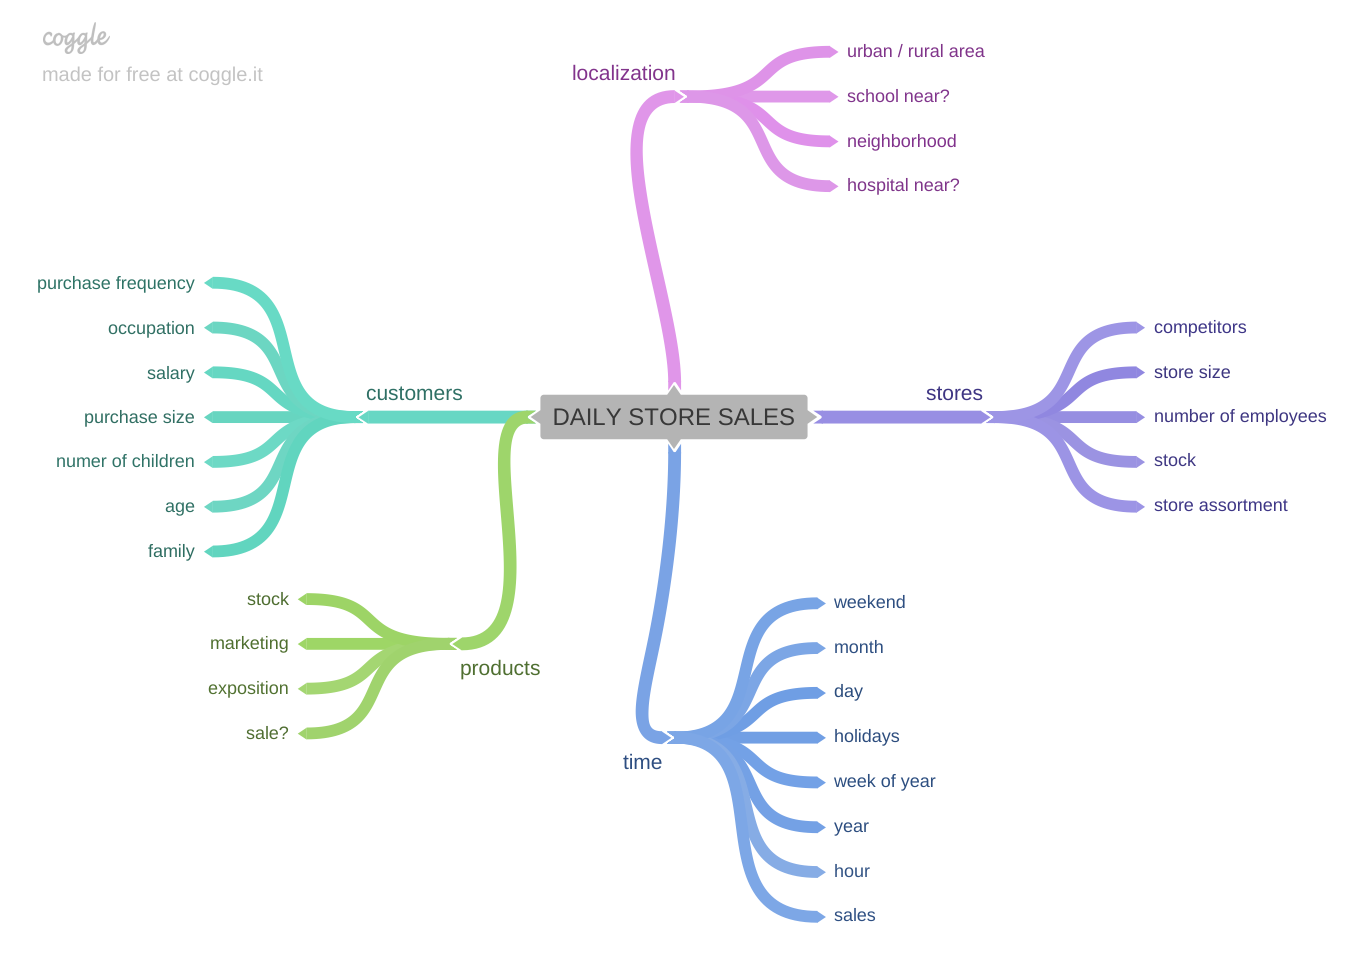

In [52]:
Image( 'Rossmann/MindMapHypotesis.png' )

### 2.2 Feature Engineering

In [54]:
df2 = df1.copy()

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x:datetime.datetime(year=x['competition_open_since_year'],
                                                                month=x['competition_open_since_month'],
                                                                day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
                                            else 'extra' if x == 'b'
                                            else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a'
                                                  else 'easter_holiday' if x == 'b'
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day' )

/tmp/ipykernel_11447/1818055778.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [55]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3. Filtering variables

In [56]:
df3 = df2.copy()

### 3.1 Filtering rows

In [57]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Selecting columns

In [58]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
